In [1]:
import torch
from torch_geometric.nn import GCNConv, GINConv, GraphConv
from torch_geometric.utils import train_test_split_edges
from itertools import combinations
import time
from torch.nn import Embedding, Sequential, Linear, ModuleList, ReLU
import argparse
import os, sys
import pickle as pkl
from tqdm import tqdm
from ogb.graphproppred import PygGraphPropPredDataset
from torch.autograd import Variable
from torch_geometric.data import Data, DataLoader
from networkx.algorithms.components import strongly_connected_components
import numpy as np
import os.path as osp
from sklearn.metrics import f1_score
from torch_geometric.data import Batch
from torch_geometric.datasets import PPI
from torch_geometric.loader import ClusterData, ClusterLoader, DataLoader
from torch_geometric.nn import BatchNorm, SAGEConv
import os.path as osp
from sklearn.metrics import f1_score
import pandas as pd
from torch_geometric.data import Batch
from torch_geometric.datasets import TUDataset, MoleculeNet, GEDDataset
from utils.GNNBenchmarkDataset import GNNBenchmarkDataset
from utils.UPFD import UPFD
from torch_geometric.loader import ClusterData, ClusterLoader, DataLoader, ShaDowKHopSampler
from torch_geometric.nn import BatchNorm, SAGEConv
from torch_geometric.utils import contains_isolated_nodes
from torch_sparse import SparseTensor, cat
from torch_scatter import scatter
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from models.model import *
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
class Args:
    def __init__(self):
        self.data_dir = '../../data'
        self.save_dir = '../../data/processed'
        self.write_dir = '.results/processed'
        self.dataset = 'PROTEINS'
        self.idx = 1
        self.gpu = 0
        self.num_clusters = 5
        self.hidden_dim = 64
        self.number_layers = 2
        self.lr = 5e-4
        
args = Args()

dataset_name = args.dataset
DATA_PATH = args.data_dir
idx = args.idx

if dataset_name in ['DD', 'MUTAG', 'PROTEINS', 'IMDB-BINARY', 'IMDB-MULTI', 'REDDIT-BINARY', 'COLLAB']:
    path = osp.join(DATA_PATH, 'TUDataset')
    dataset = TUDataset(path, name=dataset_name)
    num_splits = 10
elif dataset_name in ['brain']:
    path = osp.join(DATA_PATH, 'brain')
    with open(os.path.join(path, 'sc.pkl'), 'rb') as f:
        dataset = pkl.load(f)
    num_splits = 10
elif dataset_name in ['UPFD']:
    path = osp.join(DATA_PATH, 'UPFD')
    dataset_train = UPFD(path, feature='content', name='politifact', split='train')
    dataset_val = UPFD(path, feature='content', name='politifact', split='val')
    dataset_test = UPFD(path, feature='content', name='politifact', split='test')
elif dataset_name in ['MNIST', 'CIFAR10']:
    path = osp.join(DATA_PATH, 'GNNBenchmarkDataset')
    dataset_train = GNNBenchmarkDataset(path, name=dataset_name, split='train')
    dataset_val = GNNBenchmarkDataset(path, name=dataset_name, split='val')
    dataset_test = GNNBenchmarkDataset(path, name=dataset_name, split='test')
elif dataset_name in ['hiv', 'bace', 'bbbp']:
    path = osp.join(DATA_PATH, 'PygGraphPropPredDataset')
    dataset = PygGraphPropPredDataset(name = 'ogbg-mol'+dataset_name, root = path)   
    split_indices = dataset.get_idx_split() 
    train_indices = split_indices["train"]
    val_indices = split_indices["valid"]
    test_indices = split_indices["test"]
    dataset_train = dataset[train_indices]
    dataset_val = dataset[val_indices]
    dataset_test = dataset[test_indices]
if idx>1 and not dataset_name in ['DD', 'MUTAG', 'PROTEINS', 'IMDB-BINARY', 'IMDB-MULTI','COLLAB', 'brain', 'REDDIT-BINARY']:
    raise ValueError(dataset_name + 'does not have 10-fold validation.')
    exit()

if dataset_name in ['MNIST', 'CIFAR10', 'hiv', 'bace', 'bbbp', 'UPFD']:

    path = osp.join(args.save_dir, dataset_name)

    assert os.path.exists(path)

    with open(osp.join(path, 'batched_data_cluster'+str(args.num_clusters)+'.pkl'), 'rb') as f:
        store_dataset = pkl.load(f)

    batched_dataset_train_node = store_dataset['batched_dataset_train_node']
    batched_dataset_train_edge = store_dataset['batched_dataset_train_edge']
    clustered_edge_index_train = store_dataset['clustered_edge_index_train']
    clustered_batch_train = store_dataset['clustered_batch_train']
    y_true_train = store_dataset['y_true_train']
    batched_dataset_val_node = store_dataset['batched_dataset_val_node']
    batched_dataset_val_edge = store_dataset['batched_dataset_val_edge']
    clustered_edge_index_val = store_dataset['clustered_edge_index_val']
    clustered_batch_val = store_dataset['clustered_batch_val']
    y_true_val = store_dataset['y_true_val']
    batched_dataset_test_node = store_dataset['batched_dataset_test_node']
    batched_dataset_test_edge = store_dataset['batched_dataset_test_edge']
    clustered_edge_index_test = store_dataset['clustered_edge_index_test']
    clustered_batch_test = store_dataset['clustered_batch_test']
    y_true_test = store_dataset['y_true_test']
elif dataset_name in ['DD', 'MUTAG', 'PROTEINS', 'IMDB-BINARY', 'IMDB-MULTI','COLLAB', 'brain', 'REDDIT-BINARY']:
    i = idx
    path = osp.join(args.save_dir, dataset_name)
    with open(osp.join(path, 'batched_data_'+str(i)+'_cluster'+str(args.num_clusters)+'.pkl'), 'rb') as f:
        store_dataset = pkl.load(f)

    batched_dataset_train_node = store_dataset['batched_dataset_train_node']
    batched_dataset_train_edge = store_dataset['batched_dataset_train_edge']
    clustered_edge_index_train = store_dataset['clustered_edge_index_train']
    clustered_batch_train = store_dataset['clustered_batch_train']
    y_true_train = store_dataset['y_true_train']
    batched_dataset_test_node = store_dataset['batched_dataset_test_node']
    batched_dataset_test_edge = store_dataset['batched_dataset_test_edge']
    clustered_edge_index_test = store_dataset['clustered_edge_index_test']
    clustered_batch_test = store_dataset['clustered_batch_test']
    y_true_test = store_dataset['y_true_test']



In [3]:
dataset

PROTEINS(1113)

In [4]:
batched_dataset = DataLoader(dataset, batch_size=len(dataset))

In [5]:
for data in batched_dataset:
    pass

In [6]:
from torch_geometric.nn import WLConv
wlconv = WLConv()

In [7]:
hashed_x_first = wlconv(
    torch.ones((data.num_nodes), dtype=torch.long), 
    data.edge_index
)
hashed_x_second = wlconv(
    hashed_x_first, 
    data.edge_index
)
hist = wlconv.histogram(hashed_x_second, data.batch)

In [8]:
coarse_num_nodes = int(torch.max(clustered_edge_index_train[0])+1)
coarse_hashed_x_first = wlconv(
    torch.ones((coarse_num_nodes), dtype=torch.long), 
    clustered_edge_index_train[0]
)
coarse_hashed_x_second = wlconv(
    coarse_hashed_x_first, 
    clustered_edge_index_train[0]
)
coarse_hist = wlconv.histogram(coarse_hashed_x_second, clustered_batch_train[0])

In [9]:
fine_hist_normalized = hist.sum(axis=0)
coarse_hist_normalized = coarse_hist.sum(axis=0)
fine_hist_normalized = fine_hist_normalized / fine_hist_normalized.sum()
coarse_hist_normalized = coarse_hist_normalized / coarse_hist_normalized.sum()

In [10]:
fine_hist_normalized_np = fine_hist_normalized.numpy()
coarse_hist_normalized_np = coarse_hist_normalized.numpy()
longlength = max(len(fine_hist_normalized_np), len(coarse_hist_normalized_np))

In [11]:
fine_hist_normalized_np = np.concatenate([fine_hist_normalized_np, np.zeros(longlength - len(fine_hist_normalized_np))])
coarse_hist_normalized_np = np.concatenate([coarse_hist_normalized_np, np.zeros(longlength - len(coarse_hist_normalized_np))])

In [12]:
np.corrcoef(fine_hist_normalized_np, coarse_hist_normalized_np)

array([[1.        , 0.14344352],
       [0.14344352, 1.        ]])

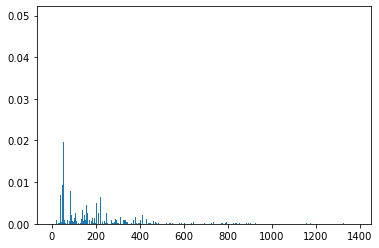

<BarContainer object of 1384 artists>

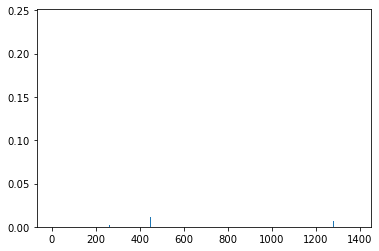

In [13]:
plt.bar(np.arange(len(fine_hist_normalized_np)), fine_hist_normalized_np)
plt.show()
plt.bar(np.arange(len(coarse_hist_normalized_np)), coarse_hist_normalized_np)

In [14]:
simCoef = np.corrcoef(fine_hist_normalized_np, coarse_hist_normalized_np)[0,1]

In [15]:
test_accuracy_list_all = []
hidden_channels = args.hidden_dim
if dataset_name in ['brain']:
    in_channels_nodes = 3
    in_channels_edges = 1
    num_classes = 8
else:
    try:
        in_channels_nodes = dataset.num_node_features
        in_channels_edges = dataset.num_edge_features
        num_classes = dataset.num_classes
    except:
        in_channels_nodes = dataset_train.num_node_features
        in_channels_edges = dataset_train.num_edge_features
        num_classes = dataset_train.num_classes

if dataset_name in ['MNIST', 'CIFAR10']:
    in_channels_nodes += 2
if in_channels_nodes == 0:
    nodes_feature_flag = False
    in_channels_nodes = 1
else:
    nodes_feature_flag = True

if in_channels_edges == 0:
    edge_feature_flag = False
    in_channels_edges = 1
else:
    edge_feature_flag = True



In [16]:
class ClusterModel(torch.nn.Module):
    def __init__(self, in_channels_nodes, in_channels_edges, hidden_channels, num_classes, num_layers, edge_feature_flag):
        super().__init__()
        self.node_linear = Linear(in_channels_nodes, hidden_channels)
        if edge_feature_flag:
            self.edge_linear = Linear(in_channels_edges, hidden_channels)
            #self.net1 = GINENet(in_channels_nodes, in_channels_edges, hidden_channels, hidden_channels, num_layers)
            self.net1 = GINENet(hidden_channels, hidden_channels, hidden_channels, hidden_channels, num_layers)
        else:
            self.net1 = GINNet(hidden_channels, hidden_channels, hidden_channels, num_layers)
            
        self.net2 = GINENet(hidden_channels, hidden_channels, hidden_channels, hidden_channels, num_layers)
        self.class_linear = Linear(hidden_channels, num_classes)
        self.edge_feature_flag = edge_feature_flag
        
    def forward(self, 
                x_node, edge_index_node, edge_attr_node, batch_node,
                x_edge, edge_index_edge, edge_attr_edge, batch_edge,
                edge_index_cluster, batch_cluster):
        x_node = self.node_linear(x_node)
        x_edge = self.node_linear(x_edge)
        if self.edge_feature_flag:
            # with edge feature
            edge_attr_node = self.edge_linear(edge_attr_node)
            edge_attr_edge = self.edge_linear(edge_attr_edge)
            edge_attr_cluster = self.net1(x_edge, edge_index_edge, edge_attr_edge, batch_edge)
            x_cluster = self.net1(x_node, edge_index_node, edge_attr_node, batch_node)
        else: 
            # no edge feature
            edge_attr_cluster = self.net1(x_edge, edge_index_edge, batch_edge)
            x_cluster = self.net1(x_node, edge_index_node, batch_node)
            
        out = self.net2(x_cluster, edge_index_cluster, edge_attr_cluster, batch_cluster)
        out = self.class_linear(out)
        return out

In [17]:
model = ClusterModel(
    in_channels_nodes=in_channels_nodes, 
    in_channels_edges=in_channels_edges, 
    hidden_channels=hidden_channels, 
    num_classes=num_classes, 
    num_layers=args.number_layers,
    edge_feature_flag=edge_feature_flag,
)

In [18]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:'+str(args.gpu))
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()#torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

def train(batched_dataset_node, batched_dataset_edge, batched_clustered_edge_index, batched_clustered_batch, batched_y_true):
    loss_value_list = []
    regularziation_value_list = []
    model.train()
    for data_node, data_edge, clustered_edge_index, clustered_batch, y_true in zip(batched_dataset_node, batched_dataset_edge, batched_clustered_edge_index, batched_clustered_batch, batched_y_true):
        edge_index_node, batch_node = data_node.edge_index, data_node.batch
        edge_index_edge, batch_edge = data_edge.edge_index, data_edge.batch
        if nodes_feature_flag:
            x_node = data_node.x.float()
            x_edge = data_edge.x.float()
        else:
            x_node = torch.zeros((data_node.num_nodes, 1))
            x_edge = torch.zeros((data_edge.num_nodes, 1))
        if edge_feature_flag:
            edge_attr_node = data_node.edge_attr.float()
            edge_attr_edge = data_edge.edge_attr.float()
        else:
            edge_attr_node = torch.zeros((data_node.num_edges, 1))
            edge_attr_edge = torch.zeros((data_edge.num_edges, 1))

        x_node, edge_index_node, edge_attr_node, batch_node = x_node.to(device), edge_index_node.to(device), edge_attr_node.to(device), batch_node.to(device)
        x_edge, edge_index_edge, edge_attr_edge, batch_edge = x_edge.to(device), edge_index_edge.to(device), edge_attr_edge.to(device), batch_edge.to(device) 

        if len(edge_attr_node.shape) == 1:
            edge_attr_node = edge_attr_node.view(-1,1)
            edge_attr_edge = edge_attr_edge.view(-1,1)
        if dataset_name in ['MNIST', 'CIFAR10']:
            pos_node = data_node.pos.float().to(device)
            x_node = torch.cat([x_node, pos_node], dim=-1)
            pos_edge = data_edge.pos.float().to(device)
            x_edge = torch.cat([x_edge, pos_edge], dim=-1)
        clustered_edge_index, clustered_batch = clustered_edge_index.to(device), clustered_batch.to(device)
        y_true = y_true.view(-1).to(device)

        out = model(
            x_node, edge_index_node, edge_attr_node, batch_node,
            x_edge, edge_index_edge, edge_attr_edge, batch_edge,
            clustered_edge_index, clustered_batch
        )
        loss = criterion(out, y_true)  # Compute the loss.
        loss_value = float(loss)
        loss_value_list.append(loss_value)
        
        # compute the regularization term
        regularization = 0
        for para1, para2 in zip(model.net1.parameters(), model.net2.parameters()):
            item = torch.sum((para1-para2)**2) 
            regularization += item
        total_para = 0
        for para in model.net1.parameters():
            total_para += len(para.view(-1))
        regularization = 10*simCoef * regularization / total_para
        regularziation_value_list.append(float(regularization))
        
        loss = loss + regularization
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return loss_value_list, regularziation_value_list

def test(batched_dataset_node, batched_dataset_edge, batched_clustered_edge_index, batched_clustered_batch, batched_y_true):
    y_pred_list = []
    model.eval()
    for data_node, data_edge, clustered_edge_index, clustered_batch, y_true in zip(batched_dataset_node, batched_dataset_edge, batched_clustered_edge_index, batched_clustered_batch, batched_y_true):
        edge_index_node, batch_node = data_node.edge_index, data_node.batch
        edge_index_edge, batch_edge = data_edge.edge_index, data_edge.batch
        if nodes_feature_flag:
            x_node = data_node.x.float()
            x_edge = data_edge.x.float()
        else:
            x_node = torch.zeros((data_node.num_nodes, 1))
            x_edge = torch.zeros((data_edge.num_nodes, 1))
        if edge_feature_flag:
            edge_attr_node = data_node.edge_attr.float()
            edge_attr_edge = data_edge.edge_attr.float()
        else:
            edge_attr_node = torch.zeros((data_node.num_edges, 1))
            edge_attr_edge = torch.zeros((data_edge.num_edges, 1))

        x_node, edge_index_node, edge_attr_node, batch_node = x_node.to(device), edge_index_node.to(device), edge_attr_node.to(device), batch_node.to(device)
        x_edge, edge_index_edge, edge_attr_edge, batch_edge = x_edge.to(device), edge_index_edge.to(device), edge_attr_edge.to(device), batch_edge.to(device) 

        if len(edge_attr_node.shape) == 1:
            edge_attr_node = edge_attr_node.view(-1,1)
            edge_attr_edge = edge_attr_edge.view(-1,1)
        if dataset_name in ['MNIST', 'CIFAR10']:
            pos_node = data_node.pos.float().to(device)
            x_node = torch.cat([x_node, pos_node], dim=-1)
            pos_edge = data_edge.pos.float().to(device)
            x_edge = torch.cat([x_edge, pos_edge], dim=-1)
        clustered_edge_index, clustered_batch = clustered_edge_index.to(device), clustered_batch.to(device)
        out = model(
            x_node, edge_index_node, edge_attr_node, batch_node,
            x_edge, edge_index_edge, edge_attr_edge, batch_edge,
            clustered_edge_index, clustered_batch
        )
        #pred = out.argmax(dim=1)  # Use the class with highest probability.
        #y_pred_list.append(pred.detach().cpu())
        out = out.softmax(dim=1)
        y_pred_list.append(out.detach().cpu())

    y_pred = torch.cat(y_pred_list)
    return y_pred 



In [19]:
start_time = time.time()
test_accuracy_list = []

directory = os.path.join(args.write_dir, args.dataset, str(args.num_clusters), str(args.idx), str(args.hidden_dim)+'_'+str(args.number_layers)+'_'+str(args.lr))
print(args.dataset, str(args.num_clusters), str(args.idx), str(args.hidden_dim), str(args.number_layers), str(args.lr))
if not os.path.exists(directory):
    os.makedirs(directory)

f = open(os.path.join(directory, 'log.txt'), 'a')
if dataset_name in ['hiv', 'bace', 'bbbp', 'UPFD']:
    print('Epoch, Loss, Reg Loss, Train rocauc, Val rocauc, Test rocauc, Time')
elif dataset_name in ['MNIST', 'CIFAR10']:
    print('Epoch, Loss, Reg Loss, Train Accuracy, Val Accuracy, Test Accuracy, Time')
else:
    print('Epoch, Loss, Reg Loss, Train Accuracy, Test Accuracy, Time')

results = []
for epoch in (range(500)):
    loss_value_list, regularziation_value_list = train(batched_dataset_train_node, batched_dataset_train_edge, clustered_edge_index_train, clustered_batch_train, y_true_train)
    y_pred_train = test(batched_dataset_train_node, batched_dataset_train_edge, clustered_edge_index_train, clustered_batch_train, y_true_train)
    y_pred_test = test(batched_dataset_test_node, batched_dataset_test_edge, clustered_edge_index_test, clustered_batch_test, y_true_test)

    loss_value = np.mean(loss_value_list)
    regularziation_value = np.mean(regularziation_value_list)

    # reshape y_true
    y_true_train_1d = torch.cat(y_true_train).view(-1).numpy()
    y_true_test_1d = torch.cat(y_true_test).view(-1).numpy()
    y_true_train_2d = np.zeros((y_true_train_1d.size, y_true_train_1d.max()+1))
    y_true_train_2d[np.arange(y_true_train_1d.size),y_true_train_1d] = 1
    y_true_test_2d = np.zeros((y_true_test_1d.size, y_true_test_1d.max()+1))
    y_true_test_2d[np.arange(y_true_test_1d.size),y_true_test_1d] = 1

    if dataset_name in ['MNIST', 'CIFAR10', 'hiv', 'bace', 'bbbp', 'UPFD']:
        y_pred_val = test(batched_dataset_val_node, batched_dataset_val_edge, clustered_edge_index_val, clustered_batch_val, y_true_val)
        y_true_val_1d = torch.cat(y_true_val).view(-1).numpy()
        y_true_val_2d = np.zeros((y_true_val_1d.size, y_true_val_1d.max()+1))
        y_true_val_2d[np.arange(y_true_val_1d.size),y_true_val_1d] = 1

    if dataset_name in ['hiv', 'bace', 'bbbp', 'UPFD']:
        train_accuracy = roc_auc_score(y_true_train_2d, y_pred_train.numpy())
        val_accuracy = roc_auc_score(y_true_val_2d, y_pred_val.numpy())
        test_accuracy = roc_auc_score(y_true_test_2d, y_pred_test.numpy())
        results.append([epoch, loss_value, regularziation_value, train_accuracy, val_accuracy, test_accuracy, time.time()-start_time])
        print("{:03d}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}".format(epoch, loss_value, regularziation_value, train_accuracy, val_accuracy, test_accuracy, time.time()-start_time))
    elif dataset_name in ['MNIST', 'CIFAR10']:
        y_pred_train, y_pred_val, y_pred_test = y_pred_train.argmax(dim=1), y_pred_val.argmax(dim=1), y_pred_test.argmax(dim=1)
        train_accuracy = accuracy_score(y_true_train_1d, y_pred_train.numpy())
        val_accuracy = accuracy_score(y_true_val_1d, y_pred_val.numpy())
        test_accuracy = accuracy_score(y_true_test_1d, y_pred_test.numpy())
        results.append([epoch, loss_value, regularziation_value, train_accuracy, val_accuracy, test_accuracy, time.time()-start_time])
        print("{:03d}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}".format(epoch, loss_value, regularziation_value, train_accuracy, val_accuracy, test_accuracy, time.time()-start_time))
    else:
        y_pred_train, y_pred_test = y_pred_train.argmax(dim=1), y_pred_test.argmax(dim=1)
        train_accuracy = accuracy_score(y_true_train_1d, y_pred_train.numpy())
        test_accuracy = accuracy_score(y_true_test_1d, y_pred_test.numpy())
        results.append([epoch, loss_value, regularziation_value, train_accuracy, test_accuracy, time.time()-start_time])
        print("{:03d}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}".format(epoch, loss_value, regularziation_value, train_accuracy, test_accuracy, time.time()-start_time))

if dataset_name in ['hiv', 'bace', 'bbbp', 'UPFD']:
    df = pd.DataFrame(data=results, columns=['Epoch', 'Loss', 'Reg Loss', 'Train rocauc', 'Val rocauc', 'Test rocauc', 'Time'])
elif dataset_name in ['MNIST', 'CIFAR10']:
    df = pd.DataFrame(data=results, columns=['Epoch', 'Loss', 'Reg Loss', 'Train Accuracy', 'Val Accuracy', 'Test Accuracy', 'Time'])
else:
    df = pd.DataFrame(data=results, columns=['Epoch', 'Loss', 'Reg Loss', 'Train Accuracy', 'Test Accuracy', 'Time'])

#df.to_csv(os.path.join(directory, 'results.csv'), index=False)




PROTEINS 5 1 64 2 0.0005
Epoch, Loss, Reg Loss, Train Accuracy, Test Accuracy, Time
000, 0.6554, 0.2505, 0.5958, 0.5946, 0.0856
001, 0.6624, 0.2501, 0.6367, 0.6306, 0.1634
002, 0.6085, 0.2497, 0.7146, 0.6667, 0.2388
003, 0.6104, 0.2493, 0.7226, 0.6667, 0.3122
004, 0.5904, 0.2489, 0.7335, 0.6667, 0.3834
005, 0.5754, 0.2485, 0.7236, 0.6486, 0.4545
006, 0.5735, 0.2481, 0.7345, 0.6577, 0.5220
007, 0.5705, 0.2477, 0.7405, 0.6847, 0.5898
008, 0.5602, 0.2473, 0.7335, 0.7027, 0.6581
009, 0.5525, 0.2469, 0.7305, 0.6667, 0.7257
010, 0.5502, 0.2465, 0.7365, 0.6847, 0.7928
011, 0.5427, 0.2461, 0.7405, 0.6757, 0.8611
012, 0.5341, 0.2457, 0.7415, 0.6847, 0.9286
013, 0.5311, 0.2453, 0.7495, 0.6757, 0.9965
014, 0.5257, 0.2449, 0.7495, 0.6937, 1.0645
015, 0.5203, 0.2446, 0.7445, 0.6757, 1.1321
016, 0.5191, 0.2442, 0.7505, 0.6847, 1.1997
017, 0.5133, 0.2438, 0.7495, 0.7027, 1.2679
018, 0.5091, 0.2434, 0.7565, 0.7027, 1.3353
019, 0.5059, 0.2430, 0.7535, 0.7027, 1.4029
020, 0.5015, 0.2426, 0.7475, 0.7027,

185, 0.4065, 0.1960, 0.8074, 0.7027, 12.6574
186, 0.4083, 0.1958, 0.7864, 0.7117, 12.7251
187, 0.4226, 0.1956, 0.7854, 0.7207, 12.7929
188, 0.4445, 0.1953, 0.7675, 0.6847, 12.8616
189, 0.5774, 0.1951, 0.7834, 0.7387, 12.9295
190, 0.4576, 0.1949, 0.7246, 0.6847, 12.9975
191, 0.5672, 0.1946, 0.7994, 0.7207, 13.0654
192, 0.4359, 0.1944, 0.7615, 0.6847, 13.1332
193, 0.4858, 0.1942, 0.7655, 0.6757, 13.2010
194, 0.4540, 0.1940, 0.7595, 0.6577, 13.2699
195, 0.4874, 0.1938, 0.7665, 0.7207, 13.3376
196, 0.4805, 0.1936, 0.7695, 0.7117, 13.4054
197, 0.4947, 0.1933, 0.7705, 0.7027, 13.4740
198, 0.4862, 0.1931, 0.7655, 0.7207, 13.5416
199, 0.4933, 0.1929, 0.7645, 0.6847, 13.6095
200, 0.4668, 0.1927, 0.7774, 0.6847, 13.6780
201, 0.4583, 0.1925, 0.7804, 0.6937, 13.7458
202, 0.4677, 0.1922, 0.7864, 0.6937, 13.8134
203, 0.4612, 0.1920, 0.7745, 0.6847, 13.8820
204, 0.4567, 0.1918, 0.7695, 0.6847, 13.9497
205, 0.4615, 0.1916, 0.7735, 0.6937, 14.0175
206, 0.4479, 0.1913, 0.7804, 0.7297, 14.0859
207, 0.447

368, 0.3534, 0.1584, 0.8244, 0.6937, 25.0855
369, 0.3740, 0.1583, 0.8473, 0.7027, 25.1530
370, 0.3465, 0.1581, 0.8323, 0.6937, 25.2206
371, 0.3619, 0.1579, 0.8134, 0.7207, 25.2885
372, 0.3889, 0.1577, 0.8253, 0.6847, 25.3564
373, 0.3652, 0.1575, 0.8114, 0.6847, 25.4238
374, 0.3808, 0.1573, 0.8403, 0.6847, 25.4917
375, 0.3365, 0.1572, 0.8244, 0.7207, 25.5593
376, 0.3675, 0.1570, 0.8523, 0.7207, 25.6270
377, 0.3415, 0.1568, 0.8563, 0.6847, 25.6950
378, 0.3539, 0.1566, 0.8313, 0.7207, 25.7625
379, 0.3410, 0.1564, 0.8283, 0.6937, 25.8301
380, 0.3553, 0.1563, 0.8343, 0.7027, 25.8982
381, 0.3538, 0.1561, 0.8353, 0.6937, 25.9658
382, 0.3366, 0.1559, 0.8453, 0.7027, 26.0333
383, 0.3321, 0.1557, 0.8453, 0.6847, 26.1013
384, 0.3400, 0.1555, 0.8443, 0.6937, 26.1692
385, 0.3432, 0.1554, 0.8553, 0.7117, 26.2370
386, 0.3249, 0.1552, 0.8513, 0.7027, 26.3050
387, 0.3234, 0.1550, 0.8413, 0.6937, 26.3726
388, 0.3344, 0.1548, 0.8523, 0.6757, 26.4404
389, 0.3271, 0.1546, 0.8533, 0.7297, 26.5083
390, 0.319